In [12]:
import os

from dotenv import load_dotenv

load_dotenv()

# Set environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# turn on langsmith tracing
#os.environ["LANGSMITH_API_KEY"] = ""
#os.environ["LANGSMITH_TRACING_V2"] = "true"

In [13]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

## Customer support tools

In [14]:
import datetime
from collections import defaultdict
from typing import Callable

from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

# Mock data for tools
RESERVATIONS = defaultdict(lambda: {"flight_info": {}, "hotel_info": {}})
TOMORROW = (datetime.date.today() + datetime.timedelta(days=1)).isoformat()
FLIGHTS = [
    {
        "departure_airport": "BOS",
        "arrival_airport": "JFK",
        "airline": "Jet Blue",
        "date": TOMORROW,
        "id": "1",
    }
]
HOTELS = [
    {
        "location": "New York",
        "name": "McKittrick Hotel",
        "neighborhood": "Chelsea",
        "id": "1",
    }
]


# Flight tools
def search_flights(
    departure_airport: str,
    arrival_airport: str,
    date: str,
) -> list[dict]:
    """Search flights.

    Args:
        departure_airport: 3-letter airport code for the departure airport. If unsure, use the biggest airport in the area
        arrival_airport: 3-letter airport code for the arrival airport. If unsure, use the biggest airport in the area
        date: YYYY-MM-DD date
    """
    # return all flights for simplicity
    return FLIGHTS


def book_flight(
    flight_id: str,
    config: RunnableConfig,
) -> str:
    """Book a flight."""
    user_id = config["configurable"].get("user_id") # type: ignore
    flight = [flight for flight in FLIGHTS if flight["id"] == flight_id][0]
    RESERVATIONS[user_id]["flight_info"] = flight
    return "Successfully booked flight"


# Hotel tools
def search_hotels(location: str) -> list[dict]:
    """Search hotels.

    Args:
        location: offical, legal city name (proper noun)
    """
    # return all hotels for simplicity
    return HOTELS


def book_hotel(
    hotel_id: str,
    config: RunnableConfig,
) -> str:
    """Book a hotel."""
    user_id = config["configurable"].get("user_id") # type: ignore
    hotel = [hotel for hotel in HOTELS if hotel["id"] == hotel_id][0]
    RESERVATIONS[user_id]["hotel_info"] = hotel
    return "Successfully booked hotel"


# Handoff tools
transfer_to_hotel_assistant = create_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant that can search for and book hotels.",
)
transfer_to_flight_assistant = create_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant that can search for and book flights.",
)


# Define agent prompt
def make_prompt(base_system_prompt: str) -> Callable[[dict, RunnableConfig], list]:
    def prompt(state: dict, config: RunnableConfig) -> list:
        user_id = config["configurable"].get("user_id") # type: ignore
        current_reservation = RESERVATIONS[user_id]
        system_prompt = (
            base_system_prompt
            + f"\n\nUser's active reservation: {current_reservation}"
            + f"Today is: {datetime.datetime.now()}"
        )
        return [{"role": "system", "content": system_prompt}] + state["messages"]

    return prompt


# Define agents
flight_assistant = create_react_agent(
    model,
    [search_flights, book_flight, transfer_to_hotel_assistant],
    prompt=make_prompt("You are a flight booking assistant"), # type: ignore
    name="flight_assistant",
)

hotel_assistant = create_react_agent(
    model,
    [search_hotels, book_hotel, transfer_to_flight_assistant],
    prompt=make_prompt("You are a hotel booking assistant"), # type: ignore
    name="hotel_assistant",
)

# Compile and run!
checkpointer = MemorySaver()
builder = create_swarm(
    [flight_assistant, hotel_assistant], default_active_agent="flight_assistant"
)

# Important: compile the swarm with a checkpointer to remember
# previous interactions and last active agent
app = builder.compile(checkpointer=checkpointer)

In [15]:
from IPython.display import Image, display

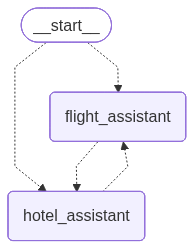

In [16]:
display(Image(app.get_graph().draw_mermaid_png()))

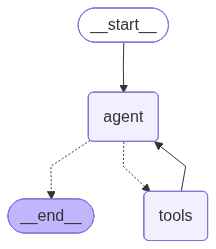

In [17]:
display(Image(flight_assistant.get_graph().draw_mermaid_png()))

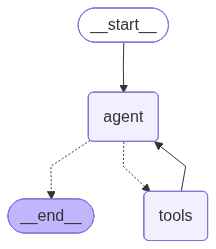

In [18]:
display(Image(hotel_assistant.get_graph().draw_mermaid_png()))

In [24]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4()), "user_id": "1"}}

In [20]:
def print_stream(stream):
    for ns, update in stream:
        for node, node_updates in update.items():
            if node_updates is None:
                continue

            if isinstance(node_updates, (dict, tuple)):
                node_updates_list = [node_updates]
            elif isinstance(node_updates, list):
                node_updates_list = node_updates
            else:
                raise ValueError(node_updates)

            for node_updates in node_updates_list:
                if isinstance(node_updates, tuple):
                    continue
                messages_key = next(
                    (k for k in node_updates.keys() if "messages" in k), None
                )
                if messages_key is not None:
                    node_updates[messages_key][-1].pretty_print()
                else:
                    pass



In [26]:
print_stream(
    app.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": "i am looking for a flight from boston to ny tomorrow, and i want to book a hotel as well",
                }
            ]
        },
        config, # type: ignore
        subgraphs=True,
    )
)

================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  search_flights (call_5WutbnouHQ1MiIhscxZDZaYQ)
 Call ID: call_5WutbnouHQ1MiIhscxZDZaYQ
  Args:
    departure_airport: BOS
    arrival_airport: JFK
    date: 2025-10-12
  transfer_to_hotel_assistant (call_LqSFXK8mc1hNsxoWx4RYaW7P)
 Call ID: call_LqSFXK8mc1hNsxoWx4RYaW7P
  Args:
================================= Tool Message =================================
Name: search_flights

[{"departure_airport": "BOS", "arrival_airport": "JFK", "airline": "Jet Blue", "date": "2025-10-12", "id": "1"}]
================================= Tool Message =================================
Name: transfer_to_hotel_assistant

Successfully transferred to hotel_assistant


ValueError: Found AIMessages with tool_calls that do not have a corresponding ToolMessage. Here are the first few of those tool calls: [{'name': 'search_flights', 'args': {'departure_airport': 'BOS', 'arrival_airport': 'JFK', 'date': '2025-10-12'}, 'id': 'call_5WutbnouHQ1MiIhscxZDZaYQ', 'type': 'tool_call'}].

Every tool call (LLM requesting to call a tool) in the message history MUST have a corresponding ToolMessage (result of a tool invocation to return to the LLM) - this is required by most LLM providers.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CHAT_HISTORY

In [10]:
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": "yes please"}]},
        config, # type: ignore
        subgraphs=True,
    )
)

================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  book_flight (call_yqnIUfILrhFo2JmGywktCsaE)
 Call ID: call_yqnIUfILrhFo2JmGywktCsaE
  Args:
    flight_id: 1
================================= Tool Message =================================
Name: book_flight

Successfully booked flight
================================== Ai Message ==================================
Name: flight_assistant

Your flight from Boston (BOS) to New York (JFK) with Jet Blue has been successfully booked for tomorrow, October 11, 2025. If you need any further assistance, such as hotel bookings or information, please let me know!
================================== Ai Message ==================================
Name: flight_assistant

Your flight from Boston (BOS) to New York (JFK) with Jet Blue has been successfully booked for tomorrow, October 11, 2025. If you need any further assistance, such as hotel bookings or information, please let me know!


In [ ]:
print_stream(
    app.stream(
        {
            "messages": [
                {"role": "user", "content": "now i'd like to book a hotel as well"}
            ]
        },
        config, # type: ignore
        subgraphs=True,
    )
)

Namespace '('flight_assistant:470ea1ba-b5a2-6164-d6e1-b6c98519aefc',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  transfer_to_hotel_assistant (call_Ufumk8HdnMnO8ll294NLOyqI)
 Call ID: call_Ufumk8HdnMnO8ll294NLOyqI
  Args:



Namespace '()'
Update from node 'flight_assistant'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  transfer_to_hotel_assistant (call_Ufumk8HdnMnO8ll294NLOyqI)
 Call ID: call_Ufumk8HdnMnO8ll294NLOyqI
  Args:
Update from node 'flight_assistant'
================================= Tool Message =================================
Name: transfer_to_hotel_assistant

Successfully transferred to hotel_assistant
Update from node 'flight_assistant'
{'active_agent': 'hotel_assistant'}



Namespace '('hotel_assistant:96312da9-559b-cfc4-43eb-73ffd7549e5a',)'
Update from node 'agent'
================================

In [25]:
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": "yes please"}]},
        config, # type: ignore
        subgraphs=True,
    )
)

================================== Ai Message ==================================
Name: flight_assistant

How can I assist you today? Would you like to book a flight or a hotel, or do you need help with something else?
================================== Ai Message ==================================
Name: flight_assistant

How can I assist you today? Would you like to book a flight or a hotel, or do you need help with something else?


In [12]:
print_stream(
    app.stream(
        {
            "messages": [
                {"role": "user", "content": "i wanna talk to flight assistant now"}
            ]
        },
        config, # type: ignore
        subgraphs=True,
    )
)

================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  transfer_to_flight_assistant (call_IYlNY99FYAlFog6wB1nxVefC)
 Call ID: call_IYlNY99FYAlFog6wB1nxVefC
  Args:
================================= Tool Message =================================
Name: transfer_to_flight_assistant

Successfully transferred to flight_assistant
================================== Ai Message ==================================
Name: flight_assistant

You are now back with the flight booking assistant. How can I assist you further?
================================== Ai Message ==================================
Name: flight_assistant

You are now back with the flight booking assistant. How can I assist you further?
